<a href="https://colab.research.google.com/github/avladova/Time-series-analysis-of-geotechnical-data-/blob/main/Prophet_thermo_ipynb%22%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
pip install prophet

     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 214 kB 13.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639418 sha256=3d91f0a1dc0829b3ee1036d07f77185ac0083849b6700cfa92fa4948b39cdd31
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3 MB 116 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Load

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import seaborn as sns
import plotly.express as px
from datetime import datetime

from sklearn.preprocessing import robust_scale
import fbprophet

In [54]:
ID='1rf9QMS8r4rGxkd-a09C2dq7EOEGyOY27tR7dOd_Amwk'
WorkSheet='Sheet1'
sheet_url = "https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}".format(ID, WorkSheet)
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
pd_otstup = pd.read_csv(url_1, index_col=False, parse_dates=['Time'])
pd_otstup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    43 non-null     datetime64[ns]
 1   h1.1    41 non-null     float64       
 2   h1.10   41 non-null     float64       
 3   h1.11   41 non-null     float64       
 4   h1.12   41 non-null     float64       
 5   h1.13   41 non-null     float64       
 6   h1.14   0 non-null      float64       
 7   h1.15   0 non-null      float64       
 8   h1.16   0 non-null      float64       
 9   h1.17   0 non-null      float64       
 10  h1.18   0 non-null      float64       
 11  h1.2    41 non-null     float64       
 12  h1.3    41 non-null     float64       
 13  h1.4    41 non-null     float64       
 14  h1.5    41 non-null     float64       
 15  h1.6    41 non-null     float64       
 16  h1.7    41 non-null     float64       
 17  h1.8    41 non-null     float64       
 18  h1.9    41 n

In [55]:
FR='W'
predictions = 1 

# Prophet

In [56]:
dist=pd.melt(pd_otstup[['h1.1','h1.6','h1.8','h1.10','h2.7','Time','well']], id_vars=["Time", "well"],  value_name="y", var_name='D.H').sort_values('y') 
dist.set_index('Time', inplace=True)

In [57]:
grouped=dist.groupby(['well', 'D.H']).resample(FR).agg({'y': np.mean}).transform(lambda x: robust_scale(x.astype(float))).dropna()

In [58]:
grouped['ds']=grouped.index.get_level_values(2)

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


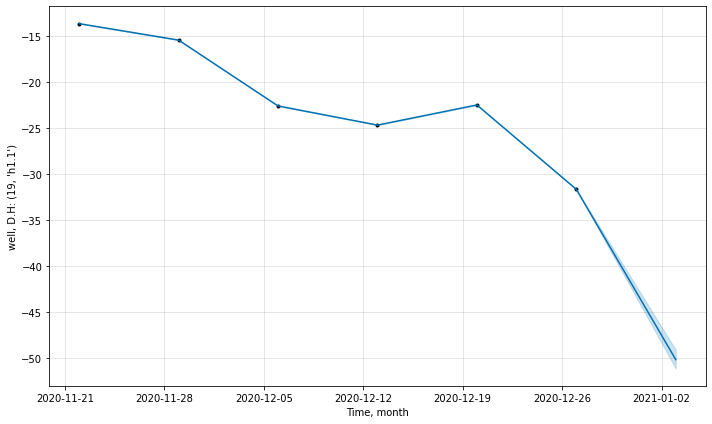

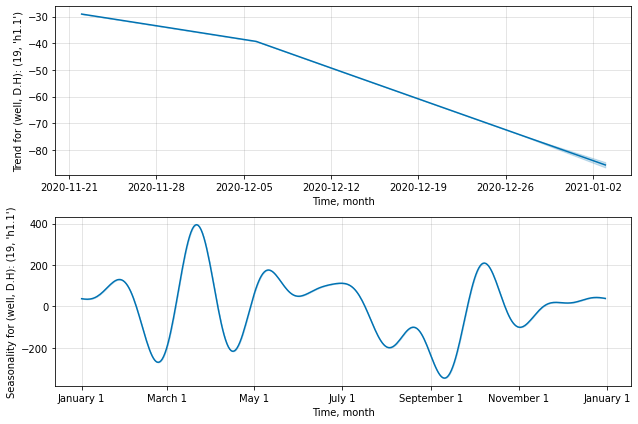

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


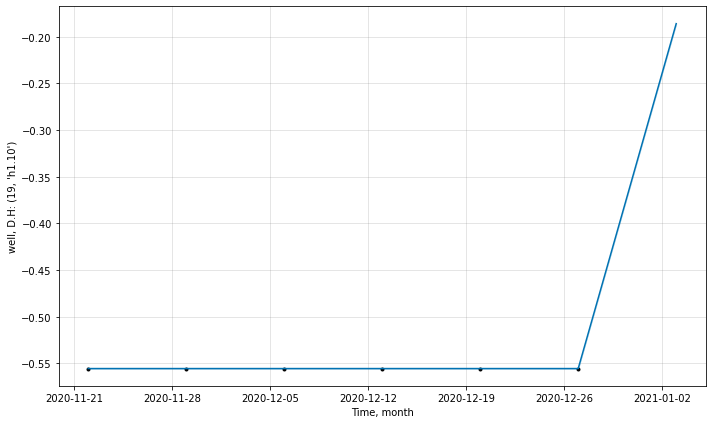

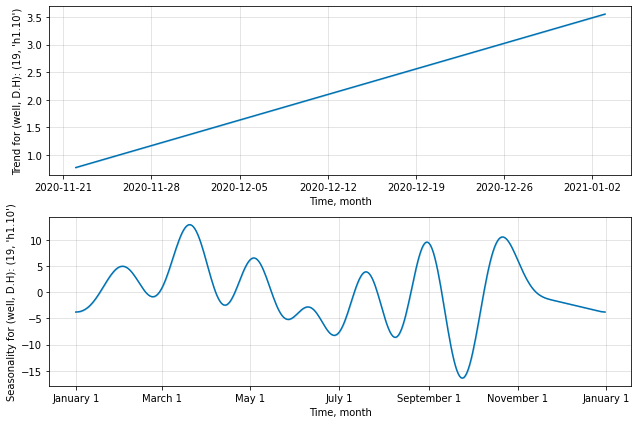

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


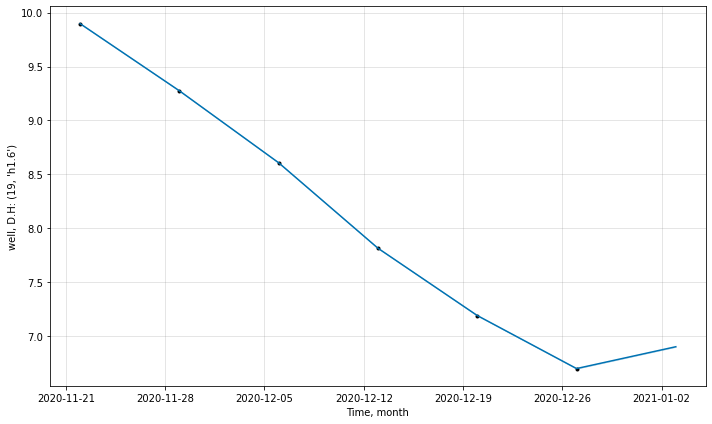

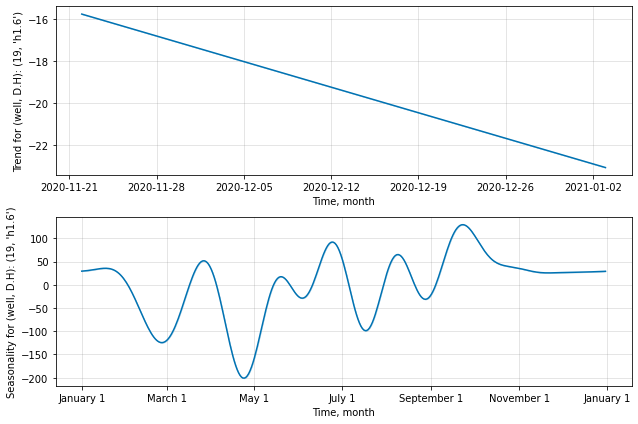

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


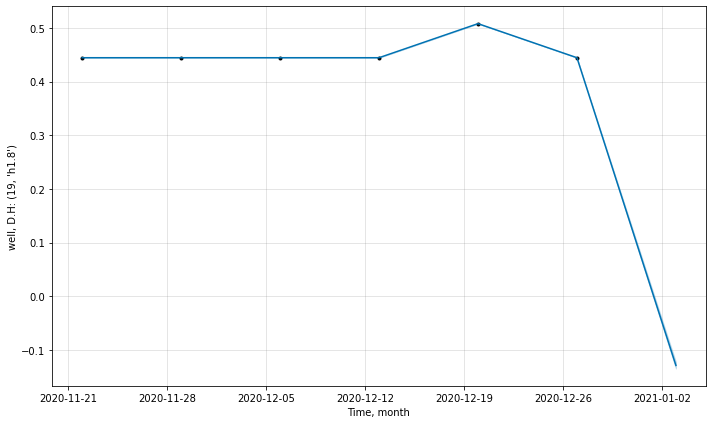

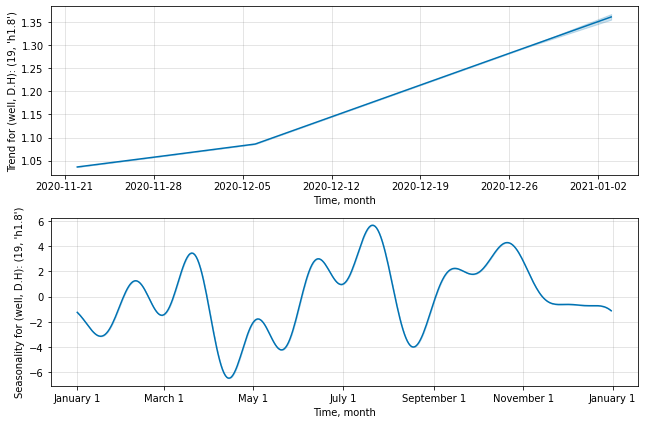

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


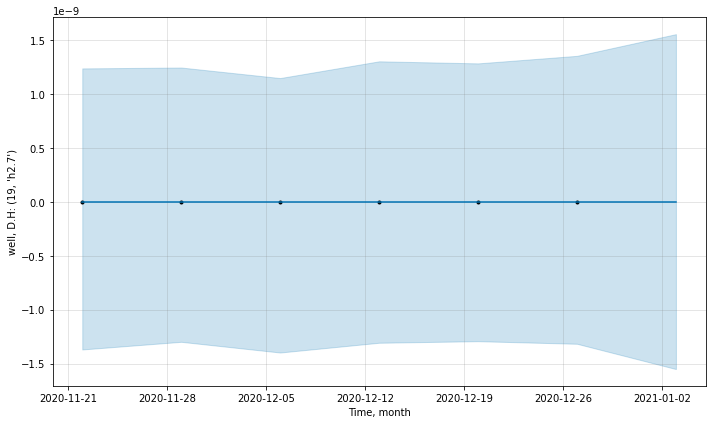

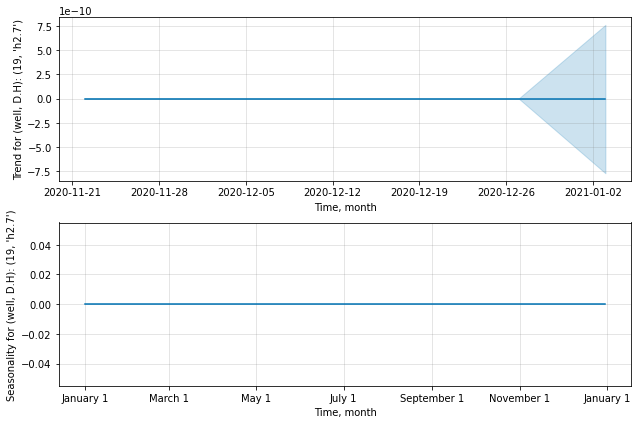

In [59]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

appended_data=[]
forecast=[]
for name, group in grouped.groupby(level=['well', 'D.H']):
      m = fbprophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
      m.fit(group[:-predictions])
      future = m.make_future_dataframe(periods=predictions,freq=FR) #прогноз на 5 месяцев
      forecast = m.predict(future)
      plt.rc('figure', max_open_warning = 0) 
      m.plot(forecast, xlabel='Time, week', ylabel = "well, D.H: "+str(name))
      fig=m.plot_components(forecast,)
      fig.get_children()[1].set_xlabel('Time, week')
      fig.get_children()[1].set_ylabel("Trend for (well, D.H): "+str(name))
      fig.get_children()[2].set_xlabel('Time, week')
      fig.get_children()[2].set_ylabel("Seasonality for (well, D.H): "+str(name))
      plt.show()
      plt.close()
      appended_data.append(forecast[['yhat', 'ds']].set_index('ds').join(group.set_index('ds')))

In [60]:
df = pd.concat(appended_data, ignore_index=True)